## To Do - process
- create directories for training, testing, and validation for each animal
- select percentage of images per training, testing, and validation
- move that percentage of images randomly from both benchmark and camera trap folders
- check how many images there are in each directory
- create batches of data to pass to the model
- plot images
- functions - top-k-predictions, top_one_k_accuracy, confusion_matrix
model training
- create model (remember to use weights)
- freeze some layers and all that stuff
- compile model
- fit model (use pretrained weights)
- save model to disk
- test model
- plot results - top-k-accuracy, confusion matrix

In [1]:
#import pandas as pd
import numpy as np
import itertools
import os
import os.path
import shutil
import random
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from operator import itemgetter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow
#import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, MaxPool2D, Dropout

# imports specific to DenseNet architecture
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

In [3]:
pip install session_info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.7 MB/s eta 0:00:00
  Created wheel for session_info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=596644a151f58e86860dadfedae7bb3df68d484673c64fc6315064571b088823
  Stored in directory: /Users/karolineseljebotn/Library/Caches/pip/wheels/10/95/8e/0027616beb8c496d40470a655c3fbb5699aec17e5004258617
Successfully built session_info
Note: you may need to restart the kernel to use updated packages.


In [4]:
import session_info

session_info.show()

## Create directories for training, testing, and validation
Currently, the images reside on disk, categorised by type of image and animal. We want the images to be categorised by training/testing/validation and animal instead.

In [5]:
# Check what directory we're in
print(os.getcwd())

/Users/karolineseljebotn/Library/Mobile Documents/com~apple~CloudDocs/Documents/01. Noroff/03. ADS3/01. UC3BPR201 Final Degree Project/FDP Code/fdp_project/ml_model


## Move images to appropriate folders and split into training, testing, and validation
The images will be divided as follows, 

In [6]:
# Get the names of all the classes from the directories
classes = []
directory = os.listdir("data/benchmark/")

for folder in directory:
    if folder != ".DS_Store":
        classes.append(folder)
        
print(classes)

['hippopotamus', 'secretarybird', 'wildebeest', 'giraffe', 'zebra', 'leopard', 'waterbuck', 'warthog', 'impala', 'hyena', 'cheetah', 'monkeyvervet', 'buffalo', 'eland', 'baboon', 'lion', 'elephant']


In [7]:
# Create variables for paths to where we want data to be stored
train_path = "data/split/train/"
valid_path = "data/split/valid/"
test_path = "data/split/test/"

paths = [train_path, valid_path, test_path]

# Create some new directories for the data if they don't already exist
if os.path.isdir("data/split/train/") is False:
    for animal in classes:
        os.makedirs(train_path + animal)
        os.makedirs(valid_path + animal)
        os.makedirs(test_path + animal)

In [ ]:
# Copying random samples of the benchmark images into the directories
# Have to decide whether to move the camera trap images like this since many of them might be from the same location
# figure out a different if statement to use here, 

if len(os.listdir("data/benchmark/"+classes[-1])) != 0:
    for animal in classes:
        # get the number of images of each animal in order to calculate a percentage to move into each section
        total_b = len(os.listdir("data/benchmark/"+animal+"/"))
        total_ct = len(os.listdir("data/camera_trap/"+animal+"/"))
        
        # --- training --- 70% ---
        for i in random.sample(glob.glob("data/benchmark/"+animal+"/"+animal+"*"), round(total_b*0.7)):
            shutil.copy2(i, paths[0] + animal)
        for i in random.sample(glob.glob("data/camera_trap/"+animal+"/"+animal+"*"), round(total_ct*0.7)):
            shutil.copy2(i, paths[0] + animal)    
        
        # --- validation --- 20% ---
        for i in random.sample(glob.glob("data/benchmark/"+animal+"/"+animal+"*"), round(total_b*0.2)):
            shutil.copy2(i, paths[1] + animal)
        for i in random.sample(glob.glob("data/camera_trap/"+animal+"/"+animal+"*"), round(total_ct*0.2)):
            shutil.copy2(i, paths[1] + animal)
        
        # --- testing --- 10% ---
        for i in random.sample(glob.glob("data/benchmark/"+animal+"/"+animal+"*"), round(total_b*0.1)):
            shutil.copy2(i, paths[2] + animal)
        for i in random.sample(glob.glob("data/camera_trap/"+animal+"/"+animal+"*"), round(total_ct*0.1)):
            shutil.copy2(i, paths[2] + animal)

        print(total_b, total_ct, animal)


In [18]:
# Copying random samples of the benchmark images into the directories
# Have to decide whether to move the camera trap images like this since many of them might be from the same location
# figure out a different if statement to use here, 

for animal in classes:
    # get the number of images of each animal in order to calculate a percentage to move into each section
    total_b = len(os.listdir("data/benchmark/"+animal+"/"))
    if '.DS_Store' in os.listdir("data/benchmark/"+animal+"/"):
        total_b -= 1
    
    total_ct = len(os.listdir("data/camera_trap/"+animal+"/"))
    if '.DS_Store' in os.listdir("data/camera_trap/"+animal+"/"):
        total_ct -=1

    # move benchmark images
    if total_b != 0:
        # --- training --- 70% ---
        for i in random.sample(glob.glob("data/benchmark/"+animal+"/"+animal+"*"), round(total_b*0.7)):
            shutil.move(i, paths[0] + animal)
        # --- validation --- 20% ---
        for i in random.sample(glob.glob("data/benchmark/"+animal+"/"+animal+"*"), round(total_b*0.2)):
            shutil.move(i, paths[1] + animal)
        # --- testing --- 10% ---
        for i in os.listdir("data/benchmark/"+animal+"/"):
            if i != ".DS_Store":
                shutil.move("data/benchmark/"+animal+"/"+i, paths[2] + animal)  
    
    # move camera trap images
    if total_ct != 0:   
        # --- training --- 70% ---
        for i in random.sample(glob.glob("data/camera_trap/"+animal+"/"+animal+"*"), round(total_ct*0.7)):
            shutil.move(i, paths[0] + animal)    
        # --- validation --- 20% ---
        for i in random.sample(glob.glob("data/camera_trap/"+animal+"/"+animal+"*"), round(total_ct*0.2)):
            shutil.move(i, paths[1] + animal)
        # --- testing --- 10% ---
        for i in os.listdir("data/camera_trap/"+animal+"/"):
            if i != ".DS_Store":
                shutil.move("data/camera_trap/"+animal+"/"+i, paths[2] + animal)

    print(total_b, total_ct, animal)


0 0 hippopotamus
0 0 secretarybird
0 0 wildebeest
0 0 giraffe
0 0 zebra
0 0 leopard
0 0 waterbuck
0 0 warthog
0 0 impala
0 0 hyena
0 0 cheetah
0 0 monkeyvervet
0 0 buffalo
0 0 eland
0 0 baboon
0 0 lion
0 0 elephant


## Check how many images there are in each directory

In [19]:
data_dir = os.listdir('data/split/')

for folder in range(len(data_dir)):
    if data_dir[folder] == "train" or data_dir[folder] == "test" or data_dir[folder] == "valid":
        
        for animal in os.listdir("data/split/" + data_dir[folder]):
            if animal != ".DS_Store":
                
                img_type_folder = os.listdir("data/split/" + data_dir[folder] + "/" + animal)
                print(data_dir[folder], " - ", animal, " - ", len(img_type_folder))
                """for bird in os.listdir("data/split/" + data_dir[folder] +"/"+ img_type):
                    if bird != ".DS_Store":
                        bird_folder = os.listdir("data/split/" + data_dir[folder] +"/"+ img_type + "/" + bird)
                        print(data_dir[folder], " - ", img_type, " - ", bird, " - ", len(bird_folder)-1)"""

valid  -  hippopotamus  -  95
valid  -  secretarybird  -  51
valid  -  wildebeest  -  67
valid  -  giraffe  -  129
valid  -  zebra  -  212
valid  -  leopard  -  87
valid  -  waterbuck  -  106
valid  -  warthog  -  120
valid  -  impala  -  124
valid  -  hyena  -  136
valid  -  cheetah  -  85
valid  -  monkeyvervet  -  112
valid  -  buffalo  -  148
valid  -  eland  -  165
valid  -  baboon  -  217
valid  -  lion  -  126
valid  -  elephant  -  165
test  -  hippopotamus  -  47
test  -  secretarybird  -  26
test  -  wildebeest  -  32
test  -  giraffe  -  63
test  -  zebra  -  105
test  -  leopard  -  43
test  -  waterbuck  -  51
test  -  warthog  -  60
test  -  impala  -  62
test  -  hyena  -  67
test  -  cheetah  -  42
test  -  monkeyvervet  -  56
test  -  buffalo  -  72
test  -  eland  -  83
test  -  baboon  -  108
test  -  lion  -  61
test  -  elephant  -  82
train  -  hippopotamus  -  331
train  -  secretarybird  -  180
train  -  wildebeest  -  236
train  -  giraffe  -  451
train  -  zeb

## Create batches of data to pass to the model

In [20]:
train_batch = str()
valid_batch = str()
test_batch = str()

batches = [train_batch, valid_batch, test_batch]

In [21]:
# Create data generators with appropriate data and parameters

def data_gen(path, function, shuffle=True, batch=10):
    # Create an ImageDataGenerator and apply appropriate preprocessing function depending on model architecture
    gen = ImageDataGenerator(preprocessing_function = function) 
    gen = gen.flow_from_directory(
            directory = path, # Path to where images are in the directory
            target_size = (224,224), # Resize images to be the same size 
            classes = classes, # Specify classes/labels
            batch_size = batch,
            shuffle = shuffle,
            seed=4)
    return gen

In [22]:
# Create data generators for the densenet model
for p in range(len(paths)):
    if "test" in paths[p]:
        batches[p] = data_gen(paths[p], preprocess_input, False)
    else:
        batches[p] = data_gen(paths[p], preprocess_input)

Found 7515 images belonging to 17 classes.
Found 2144 images belonging to 17 classes.
Found 1031 images belonging to 17 classes.


In [23]:
# This function plots images in a grid with 1 row and 10 columns

# Function is from tensorflow website
# https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [24]:
# Grab a single batch of images and their labels
imgs, labels = next(batches[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

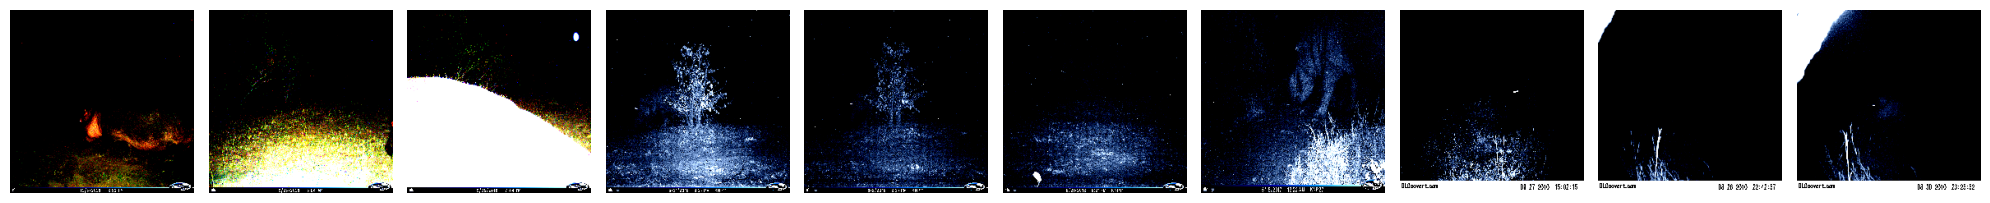

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
# This is what a training batch looks like
# The weird colours are caused by the preprocessing done using the densenet model way of preprocessing images
plotImages(imgs)
print(labels)

## Functions

In [26]:
# Stop at the ideal number of epochs, code taken from
# https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                       mode="min", patience=5,
                                       restore_best_weights=True)

In [27]:
# Function to get top 5 results from each test round
def top_k_predictions(pred, test_generator, top_k=len(classes)):
    total = []
    counter = 0
    for i in pred:
        indices, L_sorted = zip(*sorted(enumerate(i), key=itemgetter(1), reverse=True))
        new = []
        new.append([test_generator.classes[counter], classes[test_generator.classes[counter]]])

        for j in range(top_k):
            new.append([classes[indices[j]], L_sorted[j]])
        total.append(new)
        counter += 1
    totals = np.array(total)
    return totals


# Function to get top-1 and top-k accuracy
def top_one_k_accuracy(pred, test_generator, top_k):
    """Get the top1 and top5 accuracy of a prediction."""
    results = top_k_predictions(pred, test_generator)
    one = 0
    len_k = 0
    length = 0
    for r in results:
        if r[0][1] in r[1][0]:
            one += 1
        for k in range(top_k):
            if r[0][1] in r[k+1][0]:
                len_k += 1
        length += 1
    
    top_one = one/length
    k_top = len_k/length
    print("top-1 accuracy: %2f" % top_one, f"\ntop-{top_k} accuracy: %2f" % k_top)

In [53]:
## *** HAVE TO FIX THIS CODE **************

# Function to plot confusion matrix
# code from deeplizard - https://www.youtube.com/playlist?list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL
def conf_matrix(pred, test_generator):
    c = ConfusionMatrixDisplay.from_predictions(
            y_true = test_generator.classes,
            y_pred = np.argmax(pred, axis=-1),
            normalize = "all",
            display_labels=classes,
            xticks_rotation="vertical",
            cmap="Greys")
    return c

# Modified code from deeplizard - https://www.youtube.com/playlist?list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL
def prepare_image(path, file, architecture):
    """Need as input the path to where the file is, the file name, and the architecture of the model
    if you are using resnet or densenet."""
    img_path = path
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    
    # edited this part
    if architecture == "resnet":
        #return tf.keras.applications.resnet.preprocess_input(img_array_expanded_dims)
        return pre_res(img_array_expanded_dims)
    elif architecture == "densenet":
        #return tf.keras.applications.densenet.preprocess_input(img_array_expanded_dims)
        return preprocess_input(img_array_expanded_dims)
    else:
        print("no matching architecture")

---
## Testing images on model before training it
- How many of the classes in my dataset exist in the Imagenet dataset that the model is already trained on?
- How does the model perform on my data without any additional training?

In [29]:
# Get the classes from imagenet
imagenet_classes = []

with open("imagenet-classes.txt") as f:
    for line in f:
        imagenet_classes.append(line.strip().lower())
        
print(len(imagenet_classes)) # number of classes in imagenet dataset

1000


In [30]:
# compare my classes to the ones in imagenet dataset
labels = []
for animal in classes:
    labels.append(animal.replace("_", " "))

for animal in labels:
    for item in imagenet_classes:
        if animal in item:
            print(animal, "---", item)

hippopotamus --- hippopotamus, hippo, river horse, hippopotamus amphibius
zebra --- zebra
leopard --- leopard, panthera pardus
leopard --- snow leopard, ounce, panthera uncia
warthog --- warthog
impala --- impala, aepyceros melampus
hyena --- african hunting dog, hyena dog, cape hunting dog, lycaon pictus
hyena --- hyena, hyaena
cheetah --- cheetah, chetah, acinonyx jubatus
buffalo --- water buffalo, water ox, asiatic buffalo, bubalus bubalis
eland --- lakeland terrier
eland --- promontory, headland, head, foreland
baboon --- baboon
lion --- sea lion
lion --- cougar, puma, catamount, mountain lion, painter, panther, felis concolor
lion --- lion, king of beasts, panthera leo
lion --- lionfish
elephant --- indian elephant, elephas maximus
elephant --- african elephant, loxodonta africana


#### Similar classes:
- hippopotamus
- zebra
- leopard
- warthog
- impala
- hyena
- cheetah
- buffalo
- eland
- baboon
- lion
- elephant

---
### Testing DenseNet121


In [31]:
densenet = DenseNet121(
    include_top = True,
    weights = "imagenet",
    classifier_activation = "softmax")

Metal device set to: Apple M1


2023-01-21 23:02:25.501542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 23:02:25.501746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


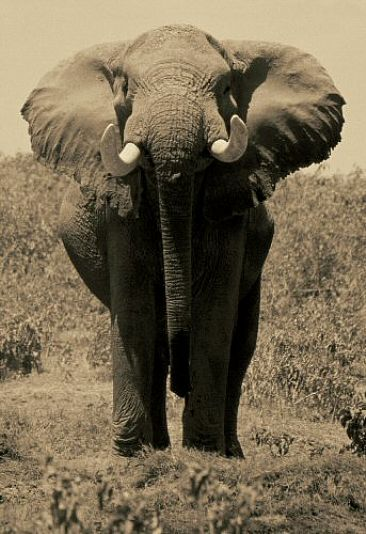

In [32]:
# Look at the first random sample to test - this animal is already present in the imagenet dataset
path = 'data/split/test/elephant/'
data_dir = os.listdir(path)
Image(filename = path + data_dir[0], width=300, height=200)

In [36]:
# Check classification of elephant in camera trap on a pretrained densenet architecture
preprocessed_image = prepare_image(path, data_dir[0], "densenet")
predictions = densenet.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

2023-01-21 23:03:35.243466: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-21 23:03:35.577233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


[[('n02504458', 'African_elephant', 0.5612251),
  ('n01871265', 'tusker', 0.37686992),
  ('n02504013', 'Indian_elephant', 0.061797284),
  ('n02397096', 'warthog', 3.9738534e-05),
  ('n01704323', 'triceratops', 1.994542e-05)]]

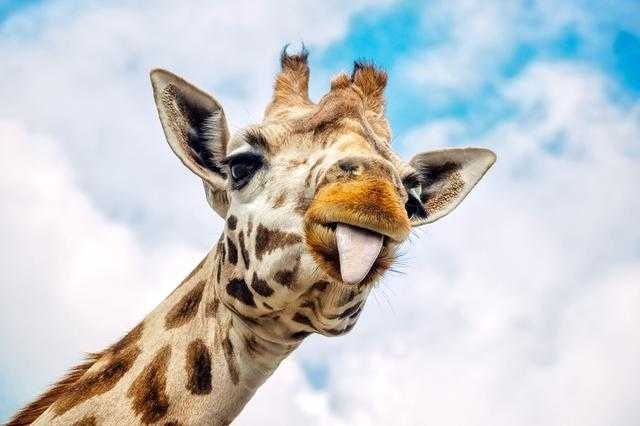

In [37]:
# Look at the first random sample to test - this animal is already present in the imagenet dataset
path = 'data/split/test/giraffe/'
data_dir = os.listdir(path)
Image(filename = path + data_dir[0], width=300, height=200)

In [39]:
# Check classification of elephant in camera trap on a pretrained densenet architecture
preprocessed_image = prepare_image(path, data_dir[0], "densenet")
predictions = densenet.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 0s 84ms/step


[[('n02128385', 'leopard', 0.26765656),
  ('n02117135', 'hyena', 0.16049847),
  ('n02116738', 'African_hunting_dog', 0.15546359),
  ('n02128925', 'jaguar', 0.12654515),
  ('n02395406', 'hog', 0.05579008)]]

---
# Build and Compile Model

In [40]:
# transfer learning
x = densenet.layers[-2].output
output = Dense(units = 17, activation = "softmax")(x)

model = Model(
    inputs = densenet.input, 
    outputs = output)

# freeze all layers except for the last 4
for layer in model.layers[:-4]:
    layer.trainable = False
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

In [41]:
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"])

### Train and save model

In [42]:
%%time
model.fit(
    x = batches[0],
    validation_data = batches[1],
    epochs = 30,
    verbose = 2,
    callbacks = [earlystopping]
)

# Check first to see if file exists already, if not, the model is saved to disk
if os.path.isfile('data/models/densenet121_v1.h5') is False:
    model.save('data/models/densenet121_v1.h5')

Epoch 1/30


2023-01-21 23:04:32.741982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 23:09:28.539582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


752/752 - 388s - loss: 2.3643 - accuracy: 0.2916 - val_loss: 1.6437 - val_accuracy: 0.5597 - 388s/epoch - 515ms/step
Epoch 2/30
752/752 - 387s - loss: 1.4726 - accuracy: 0.6233 - val_loss: 1.1209 - val_accuracy: 0.7146 - 387s/epoch - 515ms/step
Epoch 3/30
752/752 - 411s - loss: 1.1137 - accuracy: 0.7184 - val_loss: 0.8981 - val_accuracy: 0.7687 - 411s/epoch - 547ms/step
Epoch 4/30
752/752 - 388s - loss: 0.9506 - accuracy: 0.7598 - val_loss: 0.7904 - val_accuracy: 0.7859 - 388s/epoch - 516ms/step
Epoch 5/30
752/752 - 378s - loss: 0.8411 - accuracy: 0.7842 - val_loss: 0.7137 - val_accuracy: 0.8069 - 378s/epoch - 503ms/step
Epoch 6/30
752/752 - 376s - loss: 0.7750 - accuracy: 0.7957 - val_loss: 0.6688 - val_accuracy: 0.8083 - 376s/epoch - 500ms/step
Epoch 7/30
752/752 - 375s - loss: 0.7262 - accuracy: 0.8053 - val_loss: 0.6314 - val_accuracy: 0.8167 - 375s/epoch - 499ms/step
Epoch 8/30
752/752 - 375s - loss: 0.6832 - accuracy: 0.8181 - val_loss: 0.6058 - val_accuracy: 0.8256 - 375s/epoch 

### Test

In [43]:
# Get our prediction
pred = model.predict(x=batches[2], verbose=0)

loss, accuracy = model.evaluate(batches[2])
print('Test accuracy :', accuracy)

2023-01-22 11:00:11.433718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 39s 374ms/step - loss: 0.4240 - accuracy: 0.8797
Test accuracy : 0.8797284364700317


In [44]:
top_k_predictions(pred, batches[2], 5)

array([[['0', 'hippopotamus'],
        ['hippopotamus', '0.99957305'],
        ['buffalo', '0.00037408504'],
        ['hyena', '4.0700124e-05'],
        ['warthog', '4.17016e-06'],
        ['waterbuck', '3.791528e-06']],

       [['0', 'hippopotamus'],
        ['hippopotamus', '0.3435009'],
        ['baboon', '0.28803128'],
        ['waterbuck', '0.115692034'],
        ['buffalo', '0.06483182'],
        ['hyena', '0.050198127']],

       [['0', 'hippopotamus'],
        ['buffalo', '0.27327448'],
        ['hyena', '0.26521888'],
        ['hippopotamus', '0.25966945'],
        ['leopard', '0.069108285'],
        ['monkeyvervet', '0.03188026']],

       ...,

       [['16', 'elephant'],
        ['elephant', '0.99485344'],
        ['eland', '0.0046066884'],
        ['wildebeest', '0.00027247478'],
        ['buffalo', '0.00019155793'],
        ['lion', '2.3098612e-05']],

       [['16', 'elephant'],
        ['elephant', '0.994825'],
        ['zebra', '0.0021118042'],
        ['eland', '0.00

In [45]:
top_one_k_accuracy(pred, batches[2], 3)

top-1 accuracy: 0.879728 
top-3 accuracy: 0.952473


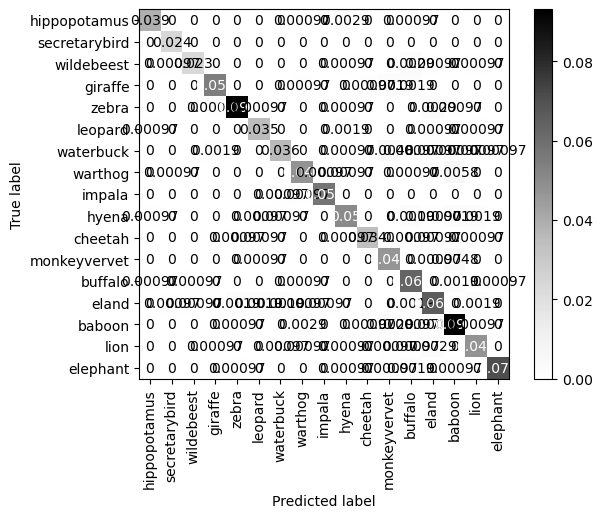

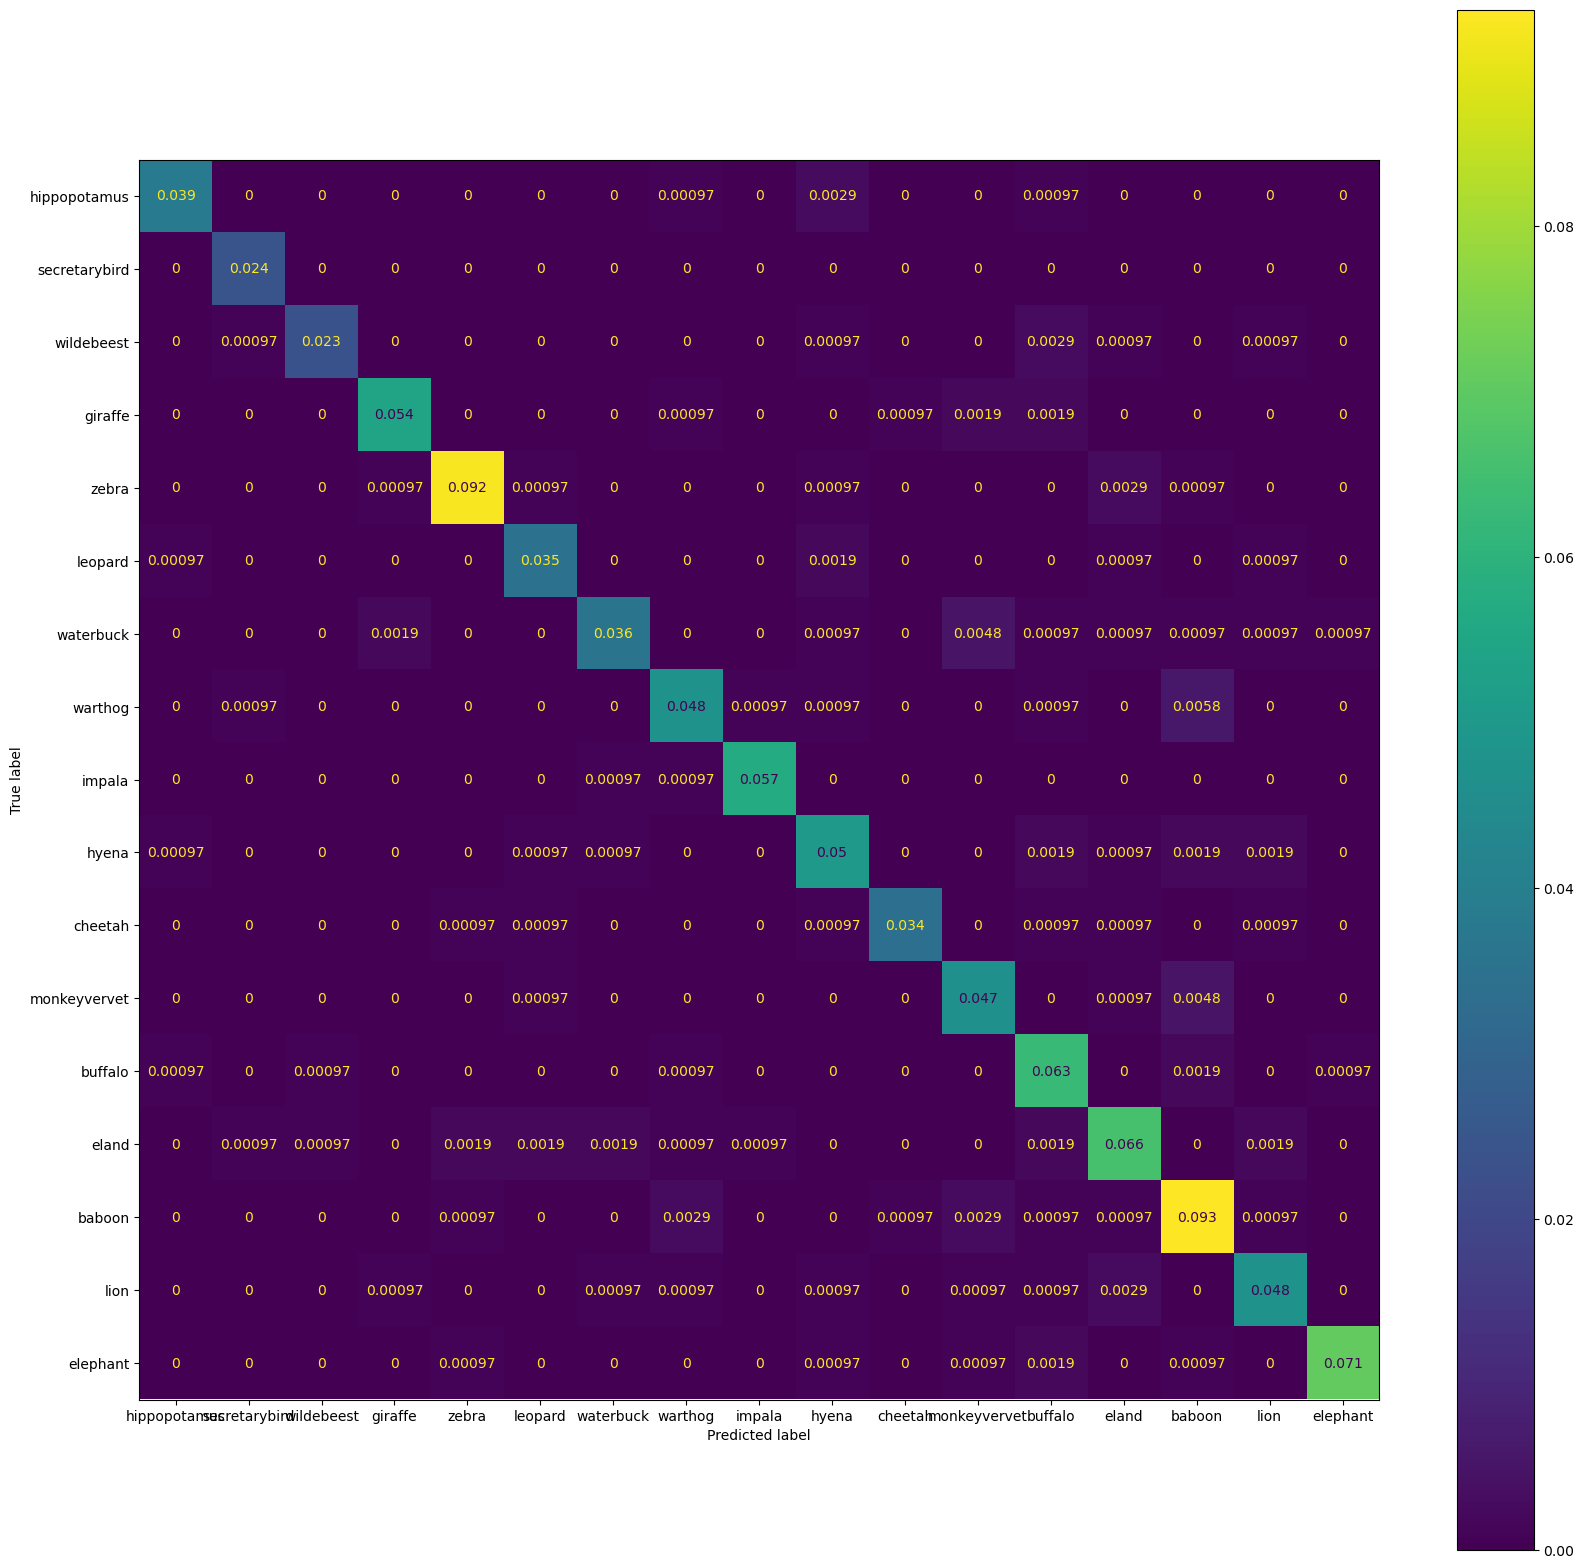

In [54]:
# this isn't really an accurate representation since the amount of testing images is different for each class.
# can try to change it to percentage of total instead
conf_matrix(pred, batches[2])